In [377]:
import numpy as np
import scipy.special as sp
from tqdm import tqdm
import seaborn as sns

In [378]:
import numpy as _np
import scipy.special as _sp
from tqdm import tqdm as _tqdm

class BayesMultiLinearModel:
    def __init__(self, n_models=20, mu = 0.1, epsilon = 10**(-30)):
        self.__n_models = n_models
        self.__mu = mu
        self.__epsilon = epsilon
        self.__A = None
        self.__b = None
        self.__beta = None
        
        
        self.__Z = None
        self.__gamma = None
        self.__B = None
        self.__m = None
        return
    
    def fit(self, X = None, p = None, epoch = 100):
        if X is None:
            return 1
        if p is None:
            return 1
        
        if self.__A is None:
            self.__A = _np.random.rand(self.__n_models, X.shape[1])
        if self.__b is None:
            self.__b = _np.random.rand(self.__n_models)
        if self.__beta is None:
            self.__beta = 1
            
        return self.__fit(X, p, epoch)
    
    def __fit(self, X, p, epoch):
        self.__init_q(X, p)
        
        for i in _tqdm(range(epoch)):
            self.__E_step(X, p)
            self.__delete_bad_model(X, p)
            self.__M_step(X, p)
        return
    
    def __delete_model(self, X, p, k):
        self.__A = _np.vstack([self.__A[:k,:], self.__A[k+1:,:]])
        self.__b = _np.hstack([self.__b[:k], self.__b[k+1:]])
        self.__n_models -= 1
        self.__Z = _np.hstack([self.__Z[:,:k], self.__Z[:,k+1:]])
        self.__Z = self.__Z/self.__Z.sum(1).reshape([-1,1])
        
        self.__gamma = _np.sum(self.__Z, axis=0)
        self.__B = _np.array([self.__B_matrix(X, p, k = i) for i in range(self.__n_models)])
        self.__m = _np.array([self.__m_vector(X, p, k = i) for i in range(self.__n_models)])
        return
    
    def __delete_bad_model(self, X, p):
        flag = 1
        while flag == 1:
            Estimation = self.__Z.sum(0)
            k = _np.argmin(Estimation)
            if Estimation[k] < self.__epsilon:
                self.__delete_model(X, p, k)
            else:
                flag = 0
            
        return
    
    def n_models(self):
        return self.__n_models
    
    def __M_step(self, X, p):
# пересчет A
        self.__A = _np.array([self.__A_matrix(k = i) for i in range(self.__n_models)])
# пересчет b
        self.__b = _np.reshape(_np.array([self.__b_scalar(X, p, k = i) for i in range(self.__n_models)]), [-1])
# пересчет beta
        self.__beta = self.__beta_scalar(X, p)
        return 0
    
    def __E_step(self, X, p):
# пересчет Z
        for i in range(X.shape[0]):
            for k in range(self.__n_models):
                temp_1 = _sp.digamma(self.__mu + self.__gamma[k]) - _sp.digamma(self.__n_models*self.__mu + X.shape[0])
                temp_2 = (p[i] - self.__b[k])**2
                temp_3 = _np.reshape(((p[i] - self.__b[k])*_np.reshape(X[i], [1, -1])@_np.reshape(self.__m[k], [-1, 1])), [-1])
                temp_4 = _np.reshape(_np.reshape(X[i], [1,-1])@(self.__B[k] + _np.reshape(self.__m[k], [-1,1])@_np.reshape(self.__m[k], [1,-1]))@_np.reshape(X[i], [-1,1]), [-1])
                self.__Z[i,k] = temp_1 - 0.5*self.__beta*(temp_2 - 2* temp_3 + temp_4)
            ex = _np.exp(self.__Z[i] - _np.max(self.__Z[i]))
            self.__Z[i] = ex/ex.sum()
        
# пересчет gamma
        self.__gamma = _np.sum(self.__Z, axis=0)
        
# пересчет w
        self.__B = _np.array([self.__B_matrix(X, p, k = i) for i in range(self.__n_models)])
        self.__m = _np.array([self.__m_vector(X, p, k = i) for i in range(self.__n_models)])
        return 0

    
    def __init_q(self, X, p):
        if self.__Z is None:
            m = X.shape[0]
            self.__Z = _np.random.rand(m, self.__n_models)
            self.__Z = self.__Z/self.__Z.sum(1).reshape([-1,1])
        if self.__gamma is None:
            self.__gamma = _np.sum(self.__Z, axis=0)
        if self.__B is None:
            self.__B = _np.array([self.__B_matrix(X, p, k = i) for i in range(self.__n_models)])
        if self.__m is None:
            self.__m = _np.array([self.__m_vector(X, p, k = i) for i in range(self.__n_models)])
        return 0
    
    def __B_matrix(self, X, p, k = 0):
        temp_1 = _np.diag(1/self.__A[k])
        temp_2 = 0
        for i in range(X.shape[0]):
            temp_2 += _np.reshape(X[i], [-1, 1])@_np.reshape(X[i], [1, -1])*self.__Z[i,k]
        return _np.linalg.inv(temp_1 + self.__beta*temp_2)
    
    def __m_vector(self, X, p, k = 0):
        temp_1 = 0
        for i in range(X.shape[0]):
            temp_1 += X[i]*(p[i] - self.__b[k])*self.__Z[i,k]
        return self.__beta*self.__B[k]@_np.reshape(temp_1, [-1, 1])
    
    def __A_matrix(self, k = 0):
        return _np.diag(self.__B[k]) + _np.diag(_np.reshape(self.__m[k], [-1,1])@_np.reshape(self.__m[k], [1,-1]))
    
    def __b_scalar(self, X, p, k = 0):
        temp_1 = 0
        temp_2 = 0
        for i in range(X.shape[0]):
            temp_1 += p[i]*self.__Z[i,k]
            temp_2 += _np.reshape(_np.reshape(X[i], [1, -1])@_np.reshape(self.__m[k], [-1, 1]), [-1])*self.__Z[i,k]
        return (temp_1 - temp_2)/(self.__Z[:,k]).sum()
    
    def __beta_scalar(self, X, p):
        temp_1 = 0
        for i in range(X.shape[0]):
            for k in range(self.__n_models):
                temp_2 = 0
                temp_2 += (p[i] - self.__b[k])**2
                temp_2 += -2*_np.reshape(((p[i] - self.__b[k])*_np.reshape(X[i], [1, -1])@_np.reshape(self.__m[k], [-1, 1])), [-1])
                temp_2 += _np.reshape(_np.reshape(X[i], [1,-1])@(self.__B[k] + _np.reshape(self.__m[k], [-1,1])@_np.reshape(self.__m[k], [1,-1]))@_np.reshape(X[i], [-1,1]), [-1])
                temp_1 += temp_2*self.__Z[i,k]
        return _np.reshape(temp_1/X.shape[0], [-1])
    
    def parameters(self):
        return self.__A, self.__b , self.__beta
    
    def q_distribution(self):
        return self.__m, self.__B, self.__Z, self.__gamma
    

In [435]:
m = 1000
n = 5
k = 2

In [436]:
X = np.random.randn(m, n)
W = np.array([np.random.normal(loc=0, scale=1, size=n) for i in range (k)])
b = np.array([np.random.normal(loc=i*5, scale=1, size=1) for i in range (k)])

In [437]:
W

array([[-0.20107261,  0.58252594,  0.56611022, -0.32034648,  1.64421817],
       [-1.56403945,  0.03593635,  1.56116254,  1.15963871,  1.32799523]])

In [438]:
w_tr = np.random.choice(k, size=m, p=[0.2, 0.8])

In [439]:
P = np.reshape(np.array([np.reshape(W[w_tr[i]], [1,-1])@np.reshape(X[i], [-1, 1]) + b[w_tr[i]] + np.random.normal(loc=0, scale=1) for i in range(m)]), [-1])

In [440]:
P.shape

(1000,)

/home/vova/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/vova/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


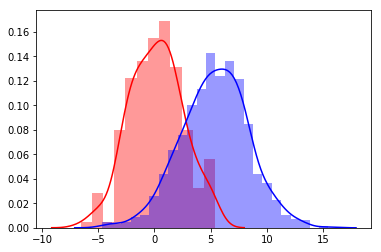

In [441]:
sns.distplot(P[w_tr == 0], color='r')
sns.distplot(P[w_tr == 1], color='b')

In [442]:
n_model = 10

In [443]:
model = BayesMultiLinearModel(n_models = n_model, mu = 0.0001)

In [444]:
model.fit(X, P, epoch=100)

100%|██████████| 100/100 [00:27<00:00,  6.58it/s]


In [425]:
A, b, beta = model.parameters()

In [426]:
b

array([-1.44651746,  7.14023162])

In [427]:
beta

array([0.9812787])

In [428]:
_, _, Z, gamma = model.q_distribution()

In [429]:
Z.sum(0)

array([200.99800641, 799.00199359])

In [433]:
correct = 0
for i in range(m):
    if (Z[i,1] > 0.95 and w_tr[i]==1) or (Z[i,0] > 0.95 and w_tr[i]==0):
        correct += 1
print(correct/m)

1.0
